In [48]:
%load_ext autoreload
%autoreload 2

from typing import Tuple
import pickle as pkl

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import numpy as np
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adam, adamw
import pandas
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# disable jax JIT
#jax.config.update("jax_disable_jit", True)

import sys
import os

sys.path.append(os.path.abspath(".."))

from scripts.vigamlss import Normal, Gamma, CustomGEV,DataPreperator, DegenerateNormal, FullCovarianceNormal, MeanFieldNormal, HalfCauchy
from scripts.vigamlss.utils.transformations import TransformationFunctions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Directories for Pickles

In [49]:
gev_fits_dir = sys.path[-1] + "/data/gev_fits"
gpd_fits_dir = sys.path[-1] + "/data/gpd_fits"
gamma_fits_dir = sys.path[-1] + "/data/gamma_fits"

## Custom Color Palettes

In [50]:
regression_palette = ["#4CAF50", "#2196F3", "#424242"]
line_palette = ["#FF5722", "#FF8F00", "#E91E63"]
loss_color = "#2C3E50"

## Plots

In [51]:
def plot_elbo(num_iterations, elbo_values, loss_color, save_path=None, file_name=None, window=None):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 3))
    if window is not None and window > 1:
        elbo_values_smoothed = pandas.Series(elbo_values).rolling(window=window, min_periods=1).mean().values
        y_values = elbo_values_smoothed
    else:
        y_values = elbo_values
    sns.lineplot(x=range(num_iterations), y=-y_values, ax=ax, color=loss_color)
    ax.set_title("ELBO over Iterations", fontsize=16)
    ax.set_xlabel("Iteration", fontsize=13)
    ax.set_ylabel("ELBO", fontsize=13)
    plt.tight_layout()
    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        if window is not None and window > 1:
            base += f"window_{window}"
        file_name_svg = base + ".svg"
        full_file_path = os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")
    plt.show()


def plot_regression_with_interval(
    scatter_x,
    scatter_y,  # Data for the scatter plot
    line_x,
    regression_y,  # Data for the regression line
    lower_hdi_bound,
    upper_hdi_bound,  # Data for the HDI
    hdi_alpha,
    palette,  # List of three colors: [scatter, regression, interval]
    scatter_label,
    regression_label,
    interval_label,
    xlabel,
    ylabel,
    title,
    fig_size=(12, 7),
    save_path=None,
    file_name=None,
):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=fig_size)

    sns.scatterplot(
        x=scatter_x,
        y=scatter_y,
        color=palette[0],
        label=scatter_label,
        alpha=0.7,
        ax=ax,
    )

    sns.lineplot(
        x=line_x,
        y=regression_y,
        color=palette[1],
        label=regression_label,
        linewidth=2.2,
        ax=ax,
    )

    ax.fill_between(
        line_x,
        lower_hdi_bound,
        upper_hdi_bound,
        color=palette[2],
        alpha=hdi_alpha,
        label=interval_label,
    )

    sns.lineplot(x=line_x, y=lower_hdi_bound, color=palette[2], ax=ax, alpha=hdi_alpha)
    sns.lineplot(x=line_x, y=upper_hdi_bound, color=palette[2], ax=ax, alpha=hdi_alpha)

    ax.legend(fontsize=10, loc="upper left")
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=14, fontweight="bold")

    plt.tight_layout()

    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")

    plt.show()


def plot_gev_gpd_syn_data(
    X,
    Y,
    regression_palette,
    line_palette,
    line1,
    line2,
    line3,
    scatter_xlabel,
    scatter_ylabel,
    scatter_title,
    line_xlabel,
    line_title,
    line1_label,
    line2_label,
    line3_label,
    file_name,
    save_path=None,
):
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.scatterplot(x=X, y=Y, alpha=0.8, s=15, color=regression_palette[0], ax=axs[0])
    axs[0].set_xlabel(scatter_xlabel)
    axs[0].set_ylabel(scatter_ylabel)
    axs[0].set_title(scatter_title)
    xs_sorted = jnp.sort(X)
    y_line1 = line1(xs_sorted)
    y_line2 = line2(xs_sorted)
    y_line3 = line3(xs_sorted)
    sns.lineplot(
        x=xs_sorted,
        y=y_line1,
        label=line1_label,
        color=line_palette[0],
        linewidth=1.5,
        ax=axs[1],
    )
    sns.lineplot(
        x=xs_sorted,
        y=y_line2,
        label=line2_label,
        color=line_palette[1],
        linewidth=1.5,
        ax=axs[1],
    )
    sns.lineplot(
        x=xs_sorted,
        y=y_line3,
        label=line3_label,
        color=line_palette[2],
        linewidth=1.5,
        ax=axs[1],
    )
    axs[1].set_xlabel(line_xlabel)
    axs[1].set_title(line_title)
    axs[1].legend()
    plt.tight_layout()
    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")
    plt.show()


## VIGAMLSS with Gamma Response

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gamma_fits/loss_gammawindow_50.svg


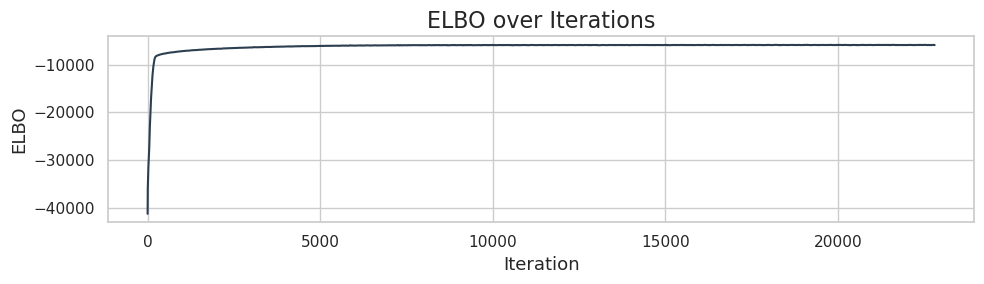

In [57]:
dbbmi_df = pandas.read_csv("../data/dbbmi_data.csv")
Y_dbbmi_np = dbbmi_df["bmi"].values
Y_dbbmi_jnp = jnp.array(Y_dbbmi_np)
X_dbbmi_np = dbbmi_df["age"].values
X_dbbmi_jnp = jnp.array(X_dbbmi_np)
X_dbbmi_DesignMatrix = DataPreperator(
    "DesignMatrix",
    X_dbbmi_jnp,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=20,
)()
K = X_dbbmi_DesignMatrix.K

dbbmi_λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
dbbmi_γ_loc = DegenerateNormal("gammas_loc", K, dbbmi_λ_loc)
dbbmi_β0_loc = Normal("beta_0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
dbbmi_λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
dbbmi_γ_scale = DegenerateNormal("gammas_scale", K, dbbmi_λ_scale)
dbbmi_β0_scale = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
Y_dbbmi = Gamma(
    "y",
    dbbmi_β0_loc + X_dbbmi_DesignMatrix @ dbbmi_γ_loc,
    dbbmi_β0_scale + X_dbbmi_DesignMatrix @ dbbmi_γ_scale,
    responses=Y_dbbmi_jnp,
)

results_dbbmi = Y_dbbmi.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=100,
    mb_size=32,
    lr=0.01,
    max_norm=5.0,
    clip_min_max_enabled=False,
    zero_nans_enabled=False,
    prng_key=PRNGKey(0),
    scheduler_type="constant",
)

with open(gamma_fits_dir + "/results_dbbmi.pkl", "wb") as f:
    pkl.dump(results_dbbmi, f)

plot_elbo(
    results_dbbmi["svi_metadata"]["num_iterations"],
    results_dbbmi["losses"],
    loss_color,
    gamma_fits_dir,
    "loss_gamma",
    window=50,
)

/tmp/ipykernel_306466/1892010145.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gamma_fits/regression_plot.svg


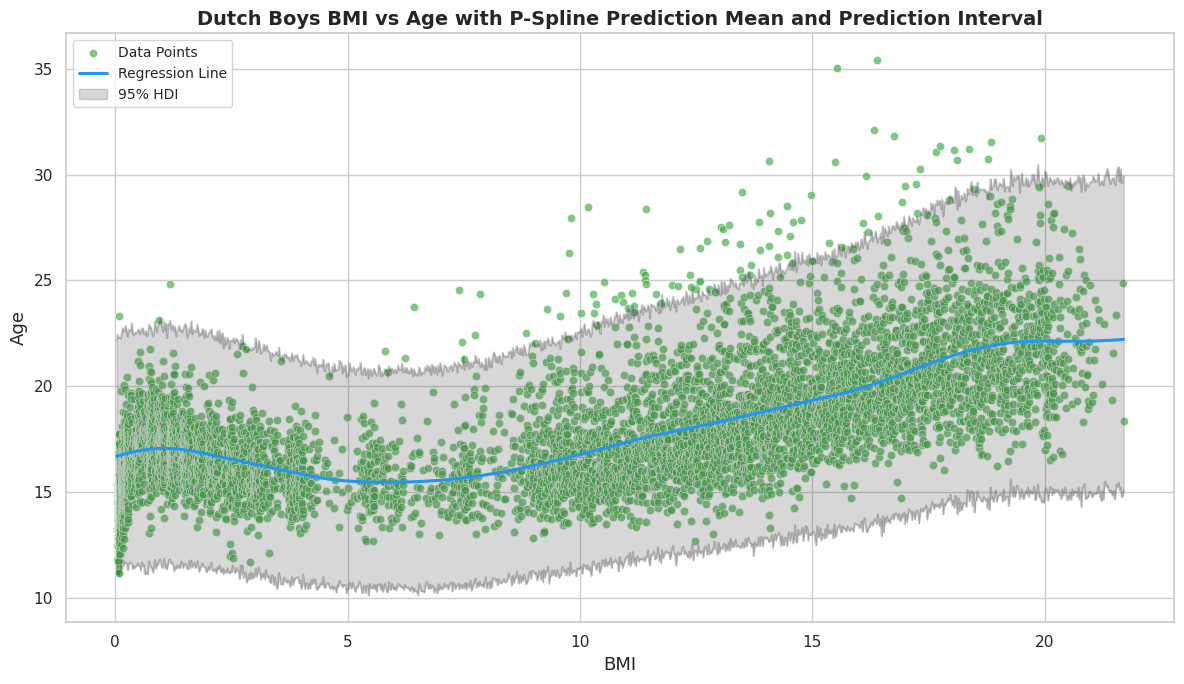

In [58]:
β0_loc = results_dbbmi["transformed_loc_vi_parameters"]["beta_0_loc"]
γ_loc = results_dbbmi["transformed_loc_vi_parameters"]["gammas_loc"]
β0_scale = results_dbbmi["transformed_loc_vi_parameters"]["beta_0_scale"]
γ_scale = results_dbbmi["transformed_loc_vi_parameters"]["gammas_scale"]

X_min, X_max = X_dbbmi_jnp.min(), X_dbbmi_jnp.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign", X_line, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
linear_predictor_concentration = TransformationFunctions.softplus(β0_loc + X_line_design.matrix @ γ_loc)
linear_predictor_rate = TransformationFunctions.softplus(β0_scale + X_line_design.matrix @ γ_scale)

GAMMAs = tfd.Gamma(linear_predictor_concentration, linear_predictor_rate)

samples = GAMMAs.sample((5000,),PRNGKey(0))
mean_line = GAMMAs.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    scatter_x=X_dbbmi_np,
    scatter_y=Y_dbbmi_np,
    line_x=X_line,
    regression_y=mean_line,
    lower_hdi_bound=hdi_lower,
    upper_hdi_bound=hdi_upper,
    hdi_alpha=0.21,
    palette=regression_palette,
    scatter_label='Data Points',
    regression_label='Regression Line',
    interval_label='95% HDI',
    xlabel='BMI',
    ylabel='Age',
    title='Dutch Boys BMI vs Age with P-Spline Prediction Mean and Prediction Interval',
    save_path=gamma_fits_dir, 
    file_name="regression_plot.svg"
)

## VIGAMLSS with GEV Response

### Synthetic Data Creation

I0000 00:00:1738687948.199219  306466 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/gev_syn_data_plot.svg


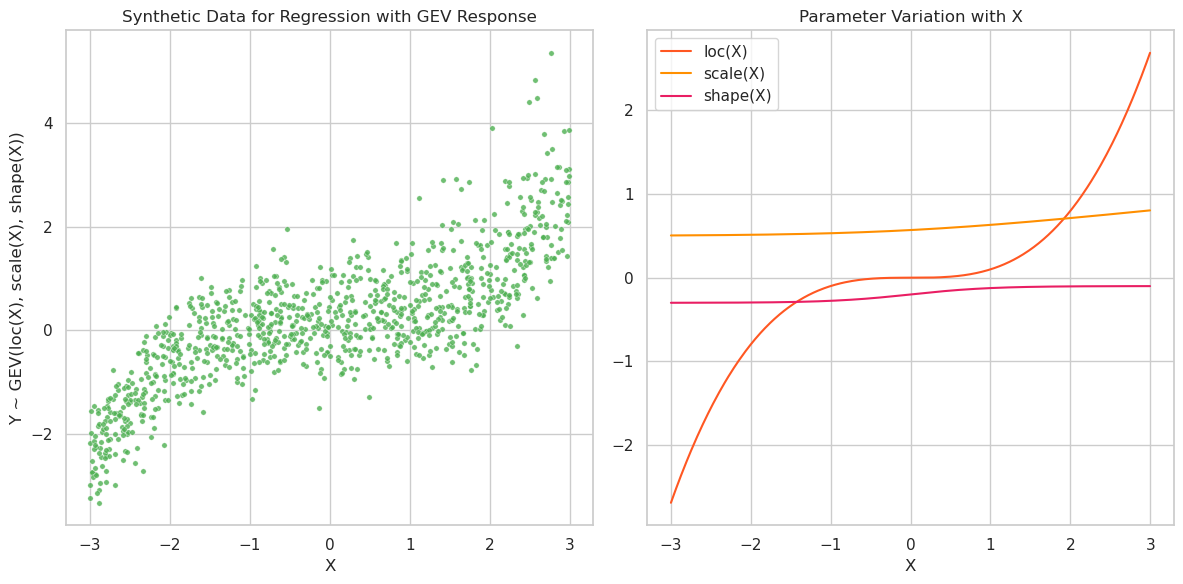

In [15]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GEV_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
xs_sorted   = jnp.sort(X_GEV_SYN)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    return 0.1 * x**3

def scale_fn(x):
    return 0.5 + TransformationFunctions.softplus(x) * 0.1

def shape_fn(x):
    return 0.1 * jnp.tanh(x) - 0.2

loc_vals   = loc_fn(X_GEV_SYN)
scale_vals = scale_fn(X_GEV_SYN)
shape_vals = shape_fn(X_GEV_SYN)

# ------------------------------------------------
# 3) Constructs a *batch* of GEVs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gev_dists = tfd.GeneralizedExtremeValue(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GEV_SYN_tf = gev_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GEV_SYN_data = jnp.array(Y_GEV_SYN_tf)


plot_gev_gpd_syn_data(
    X_GEV_SYN, 
    Y_GEV_SYN_data,
    regression_palette, 
    line_palette, 
    loc_fn,
    scale_fn,
    shape_fn,
    "X",
    "Y ~ GEV(loc(X), scale(X), shape(X))",
    "Synthetic Data for Regression with GEV Response",
    "X",
    "Parameter Variation with X",
    "loc(X)",
    "scale(X)",
    "shape(X)",
    "gev_syn_data_plot",
    gev_fits_dir,
)


### Simple Linear Predictors

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/linear_fit_loss_plotwindow_50.svg


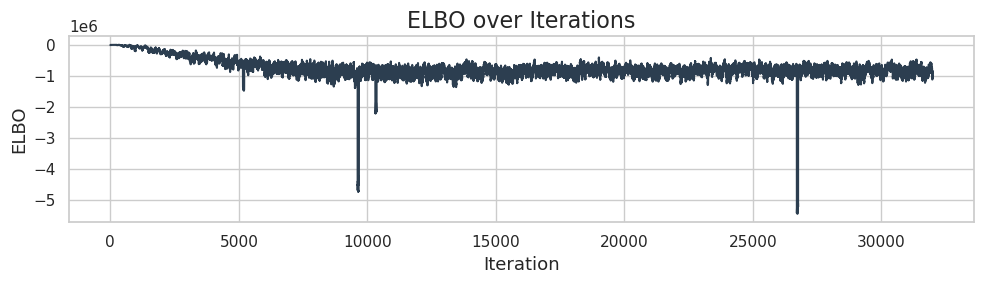

In [20]:
X_GEV_SYN_DesignMatrix = DataPreperator(
    "DesignMatrix",
    X_GEV_SYN,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = X_GEV_SYN_DesignMatrix.matrix.shape[1]

β_loc_GEV = Normal("betas_loc", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
β_scale_GEV = Normal("betas_scale", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
β_shape_GEV = Normal("betas_shape", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
Y_GEV_SYN = CustomGEV(
    "y",
    X_GEV_SYN_DesignMatrix @ β_loc_GEV,
    X_GEV_SYN_DesignMatrix @ β_scale_GEV,
    X_GEV_SYN_DesignMatrix @ β_shape_GEV,
    responses=Y_GEV_SYN_data,
)
results_GEV_SYN_SLP = Y_GEV_SYN.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=1000,
    mb_size=32,
    lr=0.0001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
    scheduler_type="constant",
    # warmup_fraction=0.2,
    # init_value=0.00001,
    # end_value=0.000001,
)

with open(gev_fits_dir + "/results_GEV_SYN_SLP.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_SLP, f)

plot_elbo(
    results_GEV_SYN_SLP["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_SLP["losses"],
    loss_color,
    gev_fits_dir,
    "linear_fit_loss_plot",
    window=50
)

/tmp/ipykernel_510125/834996069.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_slp_plot.svg


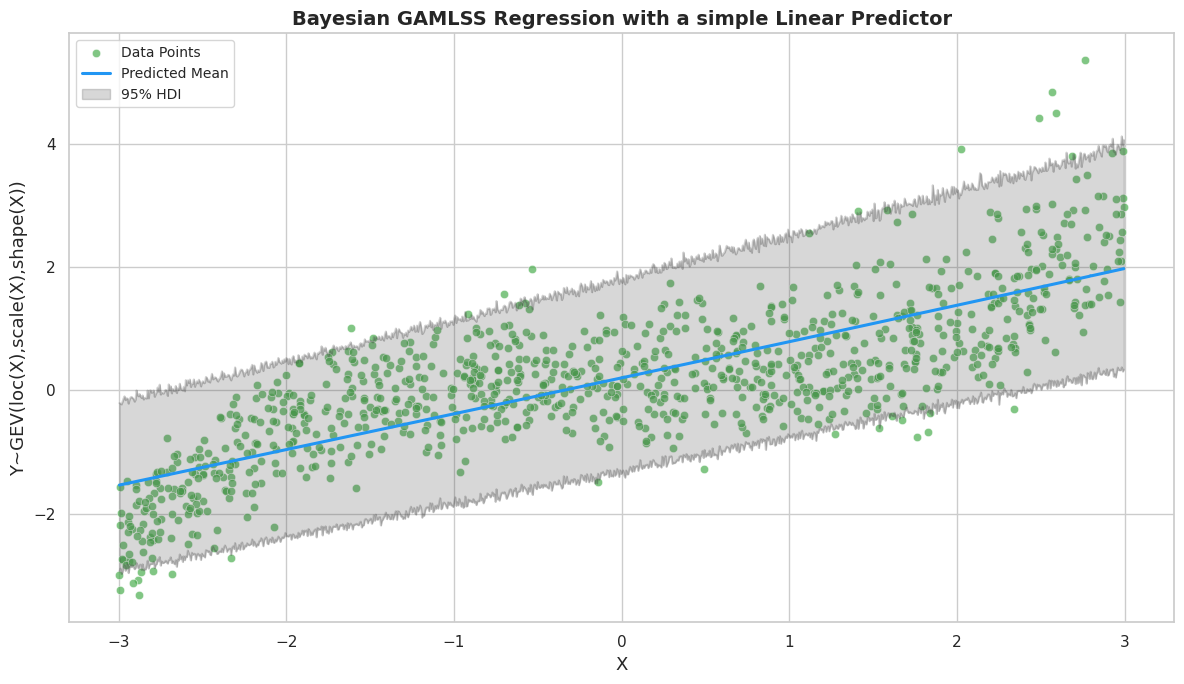

In [21]:
# Response is GPD GAMLSS Distributed Case
β_loc = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_loc"]
β_scale = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_scale"]
β_shape = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_shape"]

X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "identity",
    intercept=True,
    standardize=True,
)()
linear_predictor_loc = X_line_design.matrix @ β_loc
linear_predictor_scale = TransformationFunctions.softplus(
    X_line_design.matrix @ β_scale
)
linear_predictor_shape = X_line_design.matrix @ β_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with a simple Linear Predictor',
    save_path=gev_fits_dir, 
    file_name="regression_slp_plot.svg"
)

### PSplines

In [73]:
X_GEV_SYM_PSpline_DesignMatrix = DataPreperator(
    "xDesign",
    X_GEV_SYN,
    "pspline",
    intercept=False,
    standardize=True,
    degree=3,
    num_knots=10,
)()
K = X_GEV_SYM_PSpline_DesignMatrix.K

β0_loc_GEV_PSpline = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_loc_GEV_PSpline = HalfCauchy("lambda_loc", jnp.array([25.0]), 1)
γ_loc_GEV_PSpline = DegenerateNormal("gammas_loc", K, λ_loc_GEV_PSpline)
β0_scale_GEV_PSpline = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_scale_GEV_PSpline = HalfCauchy("lambda_scale", jnp.array([25.0]), 1)
γ_scale_GEV_PSpline = DegenerateNormal("gammas_scale", K, λ_scale_GEV_PSpline)
β0_shape_GEV_PSpline = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_shape_GEV_PSpline = HalfCauchy("lambda_shape", jnp.array([25.0]), 1)
γ_shape_GEV_PSpline = DegenerateNormal("gammas_shape", K, λ_shape_GEV_PSpline)

Y_GEV_SYN_PSpline = CustomGEV(
    "y",
    β0_loc_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_loc_GEV_PSpline,
    β0_scale_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_scale_GEV_PSpline,
    β0_shape_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_shape_GEV_PSpline,
    responses=Y_GEV_SYN_data,
)

#### Mean Field Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/PSpline_MF_10_knoloss_plotwindow_50.svg


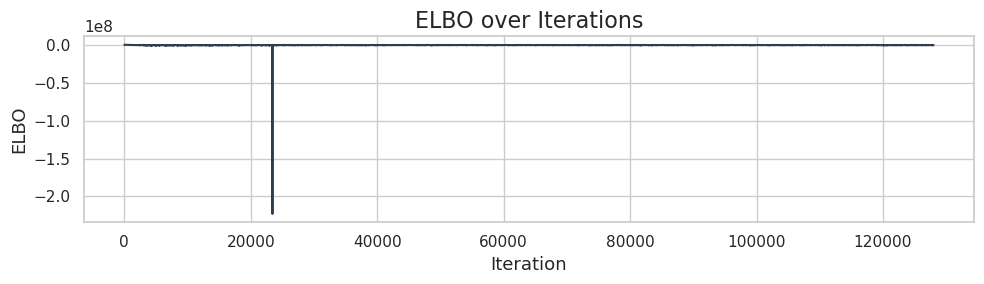

In [68]:
results_GEV_SYN_PSpline_MF = Y_GEV_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=MeanFieldNormal,
    vi_sample_size=64,
    epochs=4000,
    mb_size=32,
    lr=0.0001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.05,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gev_fits_dir + "/results_GEV_SYN_PSpline_MF.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_PSpline_MF, f)

plot_elbo(
    results_GEV_SYN_PSpline_MF["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_PSpline_MF["losses"],
    loss_color,
    gev_fits_dir,
    "PSpline_MF_10_knoloss_plot",
    window=50
)

/tmp/ipykernel_306466/861278118.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_Psplines_MF_plot.svg


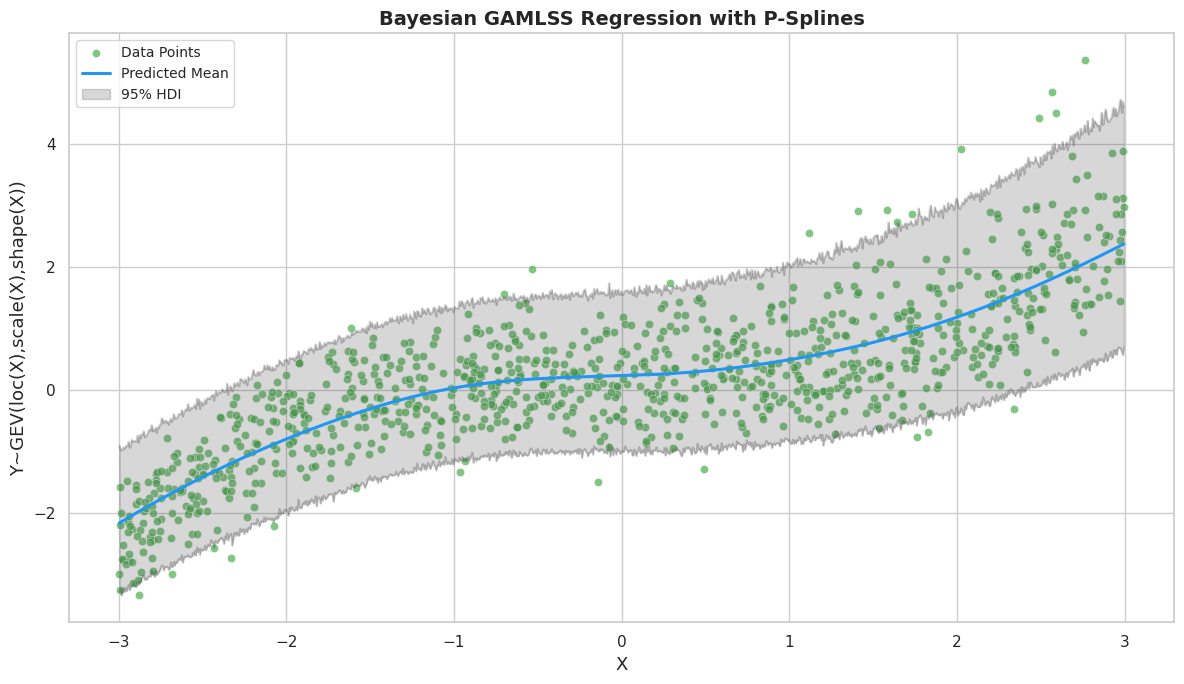

In [69]:
β0_loc = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_shape"]


X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with P-Splines',
    save_path=gev_fits_dir, 
    file_name="regression_Psplines_MF_plot.svg"
)

#### Full Covariance Gaussian VI Dist

##### 10 Knots

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/PSpline_FC_10_knots_loss_plotwindow_50.svg


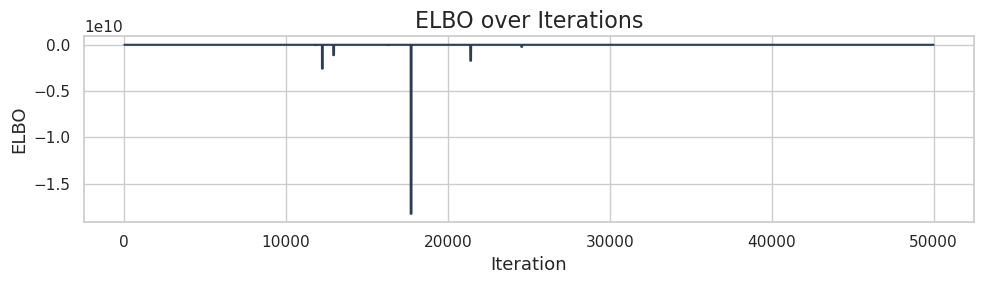

In [83]:
results_GEV_SYN_PSpline_FC = Y_GEV_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=50000,
    mb_size=None,
    lr=0.0001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(1),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.1,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gev_fits_dir + "/results_GEV_SYN_PSpline_FC.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_PSpline_FC, f)

plot_elbo(
    results_GEV_SYN_PSpline_FC["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_PSpline_FC["losses"],
    loss_color,
    gev_fits_dir,
    "PSpline_FC_10_knots_loss_plot",
    window=50
)

In [77]:
results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]

{'lambda_loc': Array([0.6877618], dtype=float32),
 'gammas_loc': Array([-0.01017947, -0.01032203,  0.009146  ,  0.01012029,  0.01018601,
         0.01021204,  0.01026203,  0.0103068 ,  0.01035755,  0.01038108,
         0.01038837], dtype=float32),
 'beta0_loc': Array([-0.01019832], dtype=float32),
 'gammas_scale': Array([ 0.01010121,  0.01019944, -0.01003216, -0.01015573, -0.01016478,
        -0.01015854, -0.01015791, -0.01012241, -0.01001826, -0.0098715 ,
        -0.00977171], dtype=float32),
 'beta0_scale': Array([0.01014251], dtype=float32),
 'lambda_scale': Array([0.6877615], dtype=float32),
 'lambda_shape': Array([0.6877607], dtype=float32),
 'beta0_shape': Array([-0.00999076], dtype=float32),
 'gammas_shape': Array([-0.00997084, -0.01006421,  0.00989506,  0.00997391,  0.0099751 ,
         0.00997343,  0.00998078,  0.00999622,  0.01005939,  0.01013591,
         0.01017159], dtype=float32)}

/tmp/ipykernel_306466/299334350.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_Psplines_FC_10knots_plot.svg


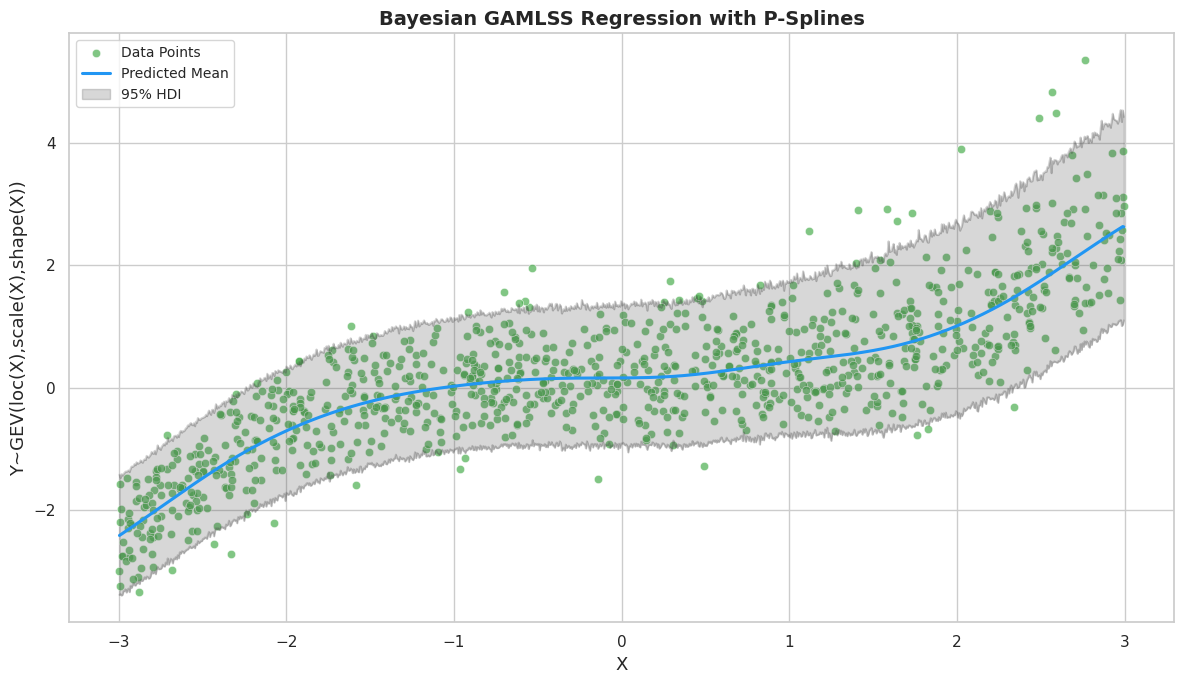

In [84]:
β0_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_shape"]


X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with P-Splines',
    save_path=gev_fits_dir, 
    file_name="regression_Psplines_FC_10knots_plot.svg"
)

##### 20 Knots

<Figure size 1200x700 with 0 Axes>

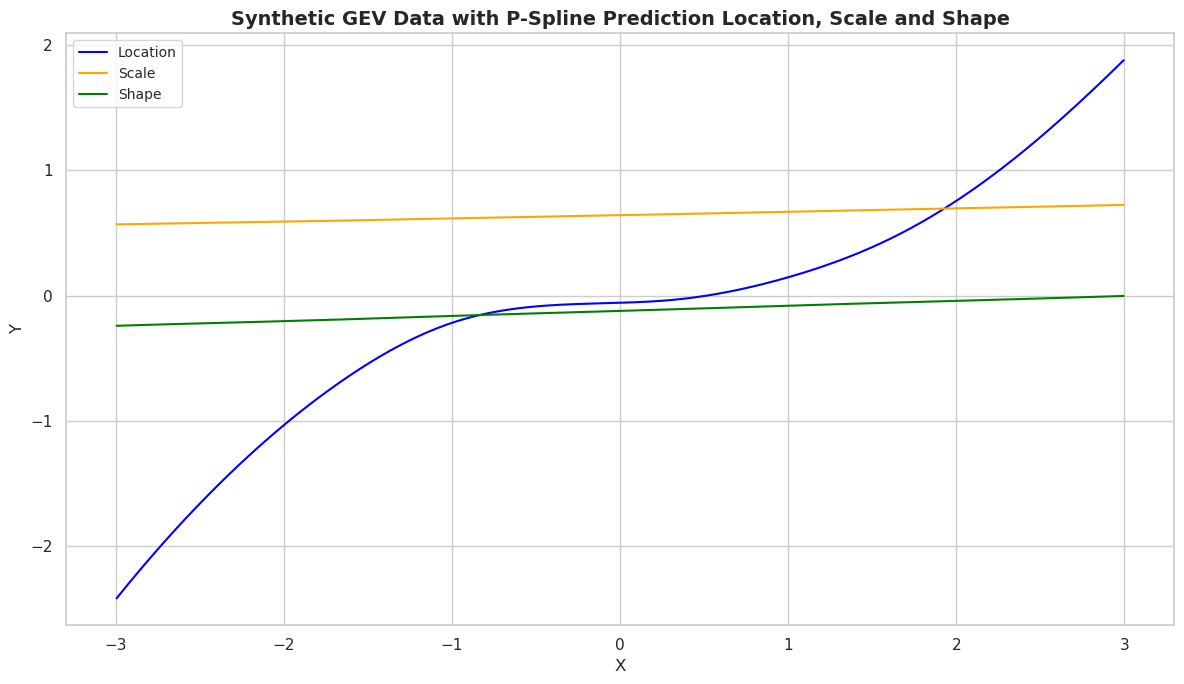

In [125]:
# plot location scale shape predicted curves
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the PSpline regression line
sns.lineplot(x=X_line, y=linear_predictor_loc, color="blue", label="Location", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_scale, color="orange", label="Scale", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_shape, color="green", label="Shape", ax=ax)

# Improve the legend
ax.legend(fontsize=10, loc="upper left")

# Customize the plot
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic GEV Data with P-Spline Prediction Location, Scale and Shape",
    fontsize=14,
    fontweight="bold",
)

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()

## GPD

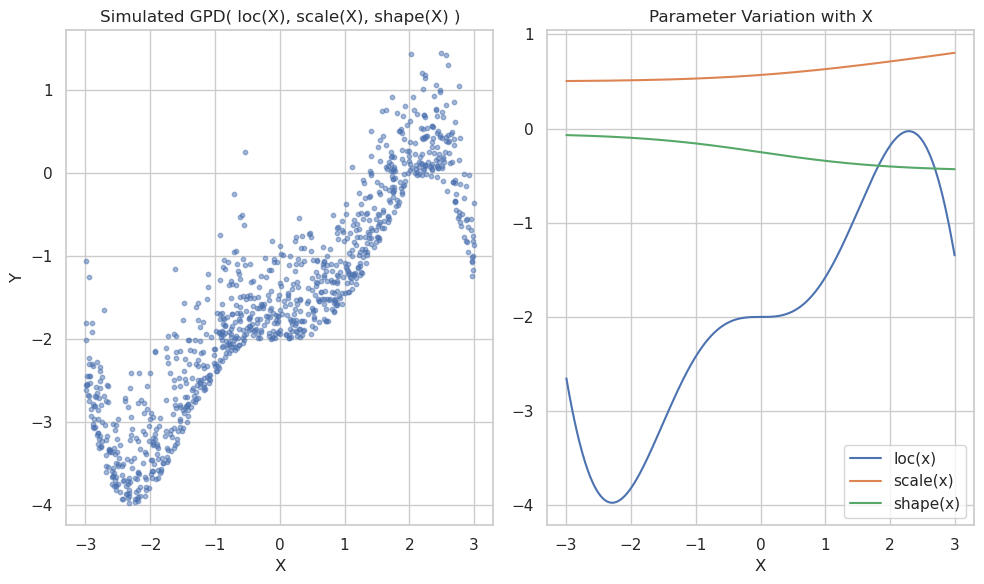

In [12]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GPD = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    """
    Location can be any real number. 
    For example: loc(x) = 0.2 * x^2 * sin(x) - 2
    """
    return 0.5 * x**2 * jnp.sin(x) - 2 

def scale_fn(x):
    """
    Scale must be strictly positive. 
    Uses softplus to ensure positivity.
    Let's do scale(x) = 1 + softplus(0.2*x).
    This will remain > 1.0 for large x and approach 1.0 for negative x.
    """
    return .5 + TransformationFunctions.softplus(x) * 0.1

def shape_fn(x):
    """
    Shape can be any real number. 
    We'll use a scaled tanh() so it transitions from negative to positive.
    For example, shape(x) = 0.3 * tanh(0.5*x).
    This yields shape in (-0.3, 0.3).
    """
    return -0.2 * jnp.tanh(0.5 * x) - 0.25

# Vectorize param values for each sample
loc_vals   = loc_fn(X_GPD)
scale_vals = scale_fn(X_GPD)
shape_vals = shape_fn(X_GPD)

# ------------------------------------------------
# 3) Construct a *batch* of GPDs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gpd_dists = tfd.GeneralizedPareto(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GPD_tf = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GPD = jnp.array(Y_GPD_tf)

# ------------------------------------------------
# 5) Optional: Visualization
# ------------------------------------------------
plt.figure(figsize=(10,6))

# Plot the (X, Y) cloud
plt.subplot(1,2,1)
plt.scatter(X_GPD, Y_GPD, alpha=0.5, s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Simulated GPD( loc(X), scale(X), shape(X) )")

# Plot how each parameter depends on X
xs_sorted = jnp.sort(X_GPD)
loc_sorted = loc_fn(xs_sorted)
scale_sorted = scale_fn(xs_sorted)
shape_sorted = shape_fn(xs_sorted)

plt.subplot(1,2,2)
plt.plot(xs_sorted, loc_sorted, label="loc(x)")
plt.plot(xs_sorted, scale_sorted, label="scale(x)")
plt.plot(xs_sorted, shape_sorted, label="shape(x)")
plt.xlabel("X")
plt.title("Parameter Variation with X")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
XDesignGPD = DataPreperator(
    "xDesign",
    X_GPD,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = XDesignGPD.matrix.shape[1]

betas_loc_GPD = Normal("betas_loc", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_scale_GPD = Normal("betas_scale", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_shape_GPD = Normal("betas_shape", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
y_GPD = CustomGEV(
    "y",
    XDesignGPD @ betas_loc_GPD,
    XDesignGPD @ betas_scale_GPD,
    XDesignGPD @ betas_shape_GPD,
    responses=Y_GPD,
)
results_GPD = y_GPD.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=10,
    mb_size=32,
    lr=0.001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
)

log_joint_pdfs:  (Traced<ConcreteArray([-11.048234], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([-11.048234], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ee51ab68650>, in_tracers=(Traced<ShapedArray(float32[1,2]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7ee51b5a8cc0; to 'JaxprTracer' at 0x7ee526bc8bd0>], out_avals=[ShapedArray(float32[1])], primitive=reduce_sum, params={'axes': (1,)}, effects=frozenset(), source_info=<jax._src.source_info_util.SourceInfo object at 0x7ee51ab6e230>, ctx=JaxprEqnContext(compute_type=None,threefry_partitionable=False),xla_metadata={}), Traced<ConcreteArray([-11.048243], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([-11.048243], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1]), None)


ValueError: All arrays must be of the same length

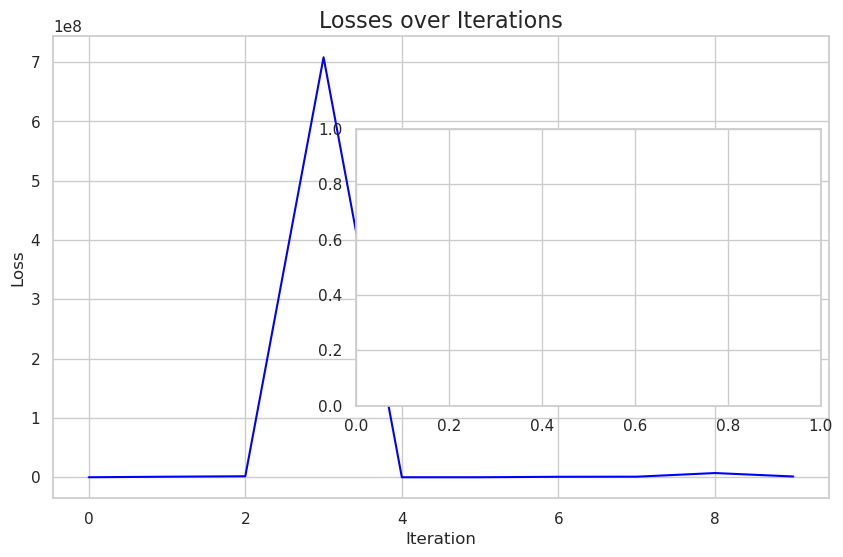

In [32]:
# Data from results GPD
num_iterations = results_GPD["svi_metadata"]["num_iterations"]
losses = results_GPD["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

#plt.tight_layout()
plt.show()

## Simple Linear Model

In [2]:
def generate_data(
    key: jax.random.PRNGKey,
    n_samples: int,
    trend_intercept: float,
    trend_slope: float,
    noise_intercept: float,
    noise_slope: float,
    x_min: float = 0.0,
    x_max: float = 1.0
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Generate heteroskedastic data with a linear trend and noise that scales linearly with x.
    
    Args:
    key: PRNG key for random number generation
    n_samples: Number of data points to generate
    trend_intercept: Y-intercept of the linear trend
    trend_slope: Slope of the linear trend
    noise_intercept: Intercept for the noise scaling
    noise_slope: Slope for the noise scaling
    x_min: Minimum value for x (default 0.0)
    x_max: Maximum value for x (default 1.0)
    
    Returns:
    x: Array of x values
    y: Array of y values with heteroskedastic noise
    """
    # Generate uniformly distributed x values between x_min and x_max
    key, subkey = jax.random.split(key)
    x = jax.random.uniform(subkey, (n_samples,), minval=x_min, maxval=x_max)
    
    # Calculate the linear trend
    y_trend = trend_intercept + trend_slope * x
    
    # Generate base noise
    key, subkey = jax.random.split(key)
    base_noise = jax.random.normal(subkey, (n_samples,))
    
    # Calculate noise scale factor (linear combination)
    noise_scale = jnp.maximum(0, noise_intercept + noise_slope * x)
    
    # Apply noise scale to base noise
    scaled_noise = base_noise * noise_scale
    
    # Combine the trend and scaled noise
    y = y_trend + scaled_noise
    
    return x, y

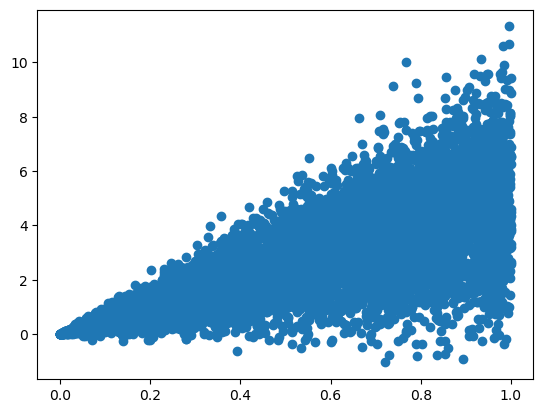

In [3]:
X_syn, Y_syn = generate_data(key = jax.random.PRNGKey(0), n_samples = 10000, trend_intercept = 0.0, trend_slope = 5.0, noise_intercept = 0, noise_slope = 2)
plt.scatter(X_syn, Y_syn)

In [8]:
XDesignSyn = DataPreperator(
    "xDesign",
    X_syn,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = XDesignSyn.matrix.shape[1]

betas_loc_syn = Normal("betas_loc", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
betas_scale_syn = Normal("betas_scale", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
y_Normal = Normal(
    "y",
    XDesignSyn @ betas_loc_syn,
    XDesignSyn @ betas_scale_syn,
    responses=Y_syn,
)
results_syn = y_Normal.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=10,
    mb_size=32,
    lr=0.01,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
)

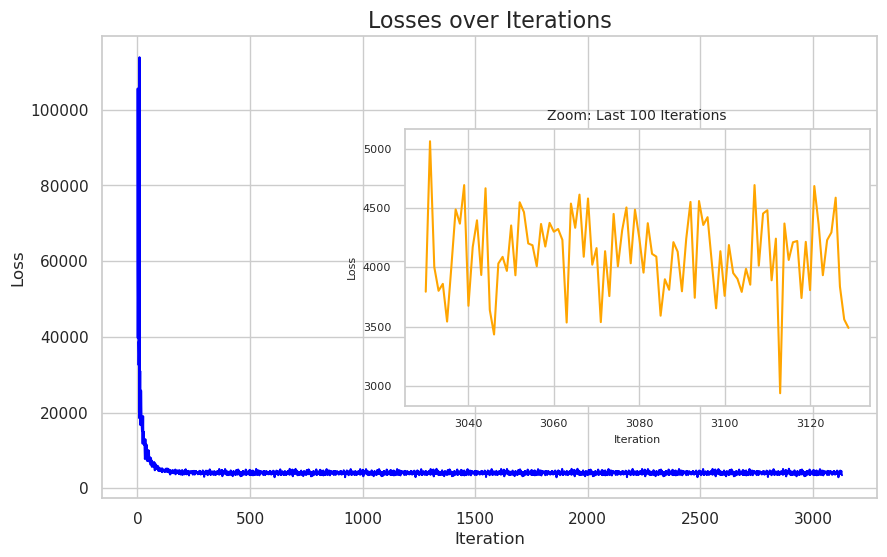

In [9]:
# Data from results GPD
num_iterations = results_syn["svi_metadata"]["num_iterations"]
losses = results_syn["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

#plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

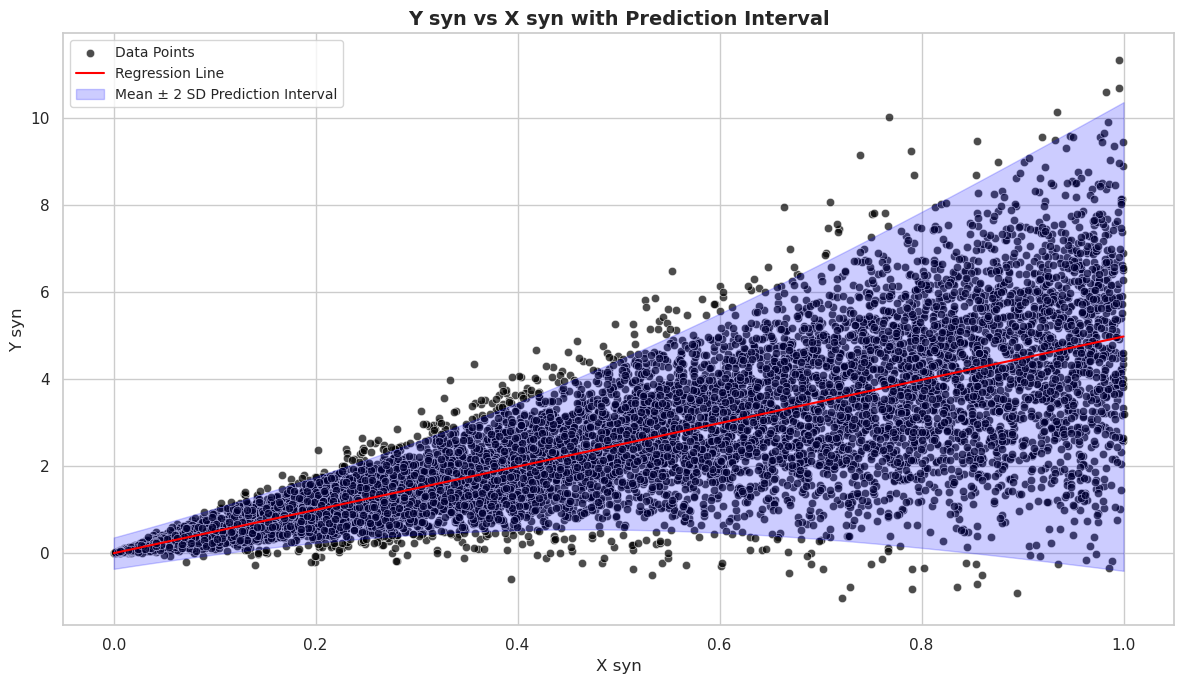

In [12]:
# Response is Gamma Distributed Case
betas_mu = results_syn["transformed_loc_vi_parameters"]["betas_loc"]
betas_scale = results_syn["transformed_loc_vi_parameters"]["betas_scale"]

X_min, X_max = X_syn.min(), X_syn.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign", X_line, "identity", intercept=True, standardize=True
)()
linear_predictor_mu = X_line_design.matrix @ betas_mu
linear_predictor_scale = TransformationFunctions.softplus(X_line_design.matrix @ betas_scale)

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the plot
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data, y axis label is age, a x axis label is bmi
sns.scatterplot(x=X_syn, y=Y_syn, color='black', label='Data Points', alpha=0.7, ax=ax)

# Plot the PsSpline regression line
sns.lineplot(x=X_line, y=linear_predictor_mu, color='red', label='Regression Line', ax=ax)

# Calculate the standard deviation
Y_lower = linear_predictor_mu - 2 * linear_predictor_scale
Y_upper = linear_predictor_mu + 2 * linear_predictor_scale

# Add the two standard deviation interval
ax.fill_between(X_line, Y_lower, Y_upper, color='blue', alpha=0.2, 
                label='Mean ± 2 SD Prediction Interval')

# Improve the legend
ax.legend(fontsize=10, loc='upper left')

# Customize the plot
ax.set_xlabel('X syn', fontsize=12)
ax.set_ylabel('Y syn', fontsize=12)
ax.set_title('Y syn vs X syn with Prediction Interval', fontsize=14, fontweight='bold')

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()

## GEV Synthetic Data Approach

/tmp/ipykernel_31948/3198763542.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_maxima = df.resample("Y").max()


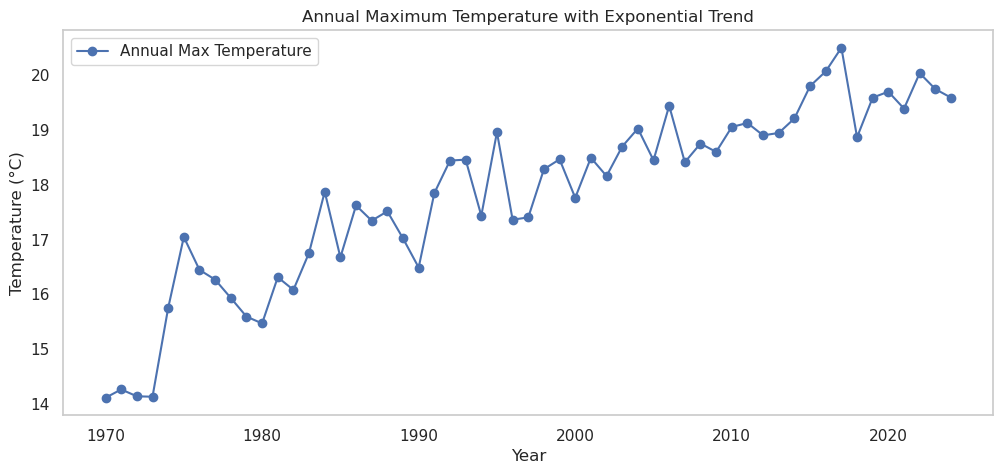

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series
np.random.seed(42)
dates = pd.date_range(start="1970-01-01", end="2024-12-31", freq="D")
n = len(dates)

# Base temperature values (random fluctuations)
temperature = np.random.beta(a=2, b=5, size=n) * 10  # Base around ~10°C
#temperature = np.minimum(temperature, np.percentile(temperature, 99))

# Introduce an exponential trend
years = (dates.year - 1970) / (2021 - 1970)  # Normalize years between 0 and 1
trend = np.log(1 + years * 2)  # Logarithmic trend instead of exponential

# Scale the trend to a reasonable range
trend *= 5  # Adjust scaling factor to control impact

# Apply the trend to temperature
temperature = 10 + np.random.normal(scale=1.5, size=n) + trend

# Create a pandas DataFrame
df = pd.DataFrame({"date": dates, "temperature": temperature})
df.set_index("date", inplace=True)

# Resample to find annual maxima (Block Maxima method)
annual_maxima = df.resample("Y").max()

# Rename the index column for clarity
annual_maxima.index = annual_maxima.index.year

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(annual_maxima.index, annual_maxima["temperature"], marker="o", linestyle="-", label="Annual Max Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Annual Maximum Temperature with Exponential Trend")
plt.legend()
plt.grid()
plt.show()


In [18]:
X_temp = jnp.array(annual_maxima.index.to_numpy())
Y_temp = jnp.array(annual_maxima["temperature"].to_numpy())

In [26]:
XDesignTemp = DataPreperator(
    "xDesign",
    X_temp,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = XDesignTemp.matrix.shape[1]

betas_loc_temp = Normal("betas_loc", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
betas_scale_temp = Normal("betas_scale", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
betas_shape_temp = Normal("betas_shape", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
y_Normal = CustomGEV(
    "y",
    XDesignTemp @ betas_loc_temp,
    XDesignTemp @ betas_scale_temp,
    XDesignTemp @ betas_shape_temp,
    responses=Y_temp,
)
results_temp = y_Normal.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=10000,
    mb_size=64,
    lr=0.001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
)

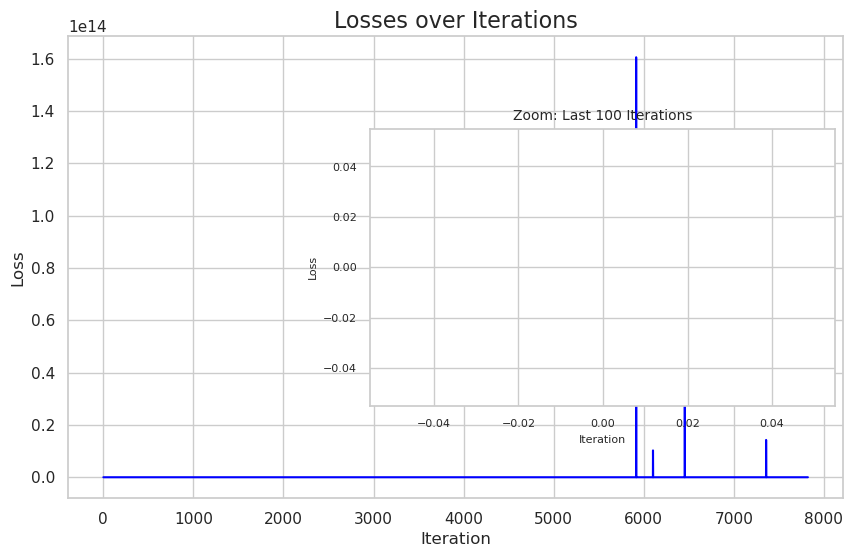

In [27]:
# Data from results GPD
num_iterations = results_temp["svi_metadata"]["num_iterations"]
losses = results_temp["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

#plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

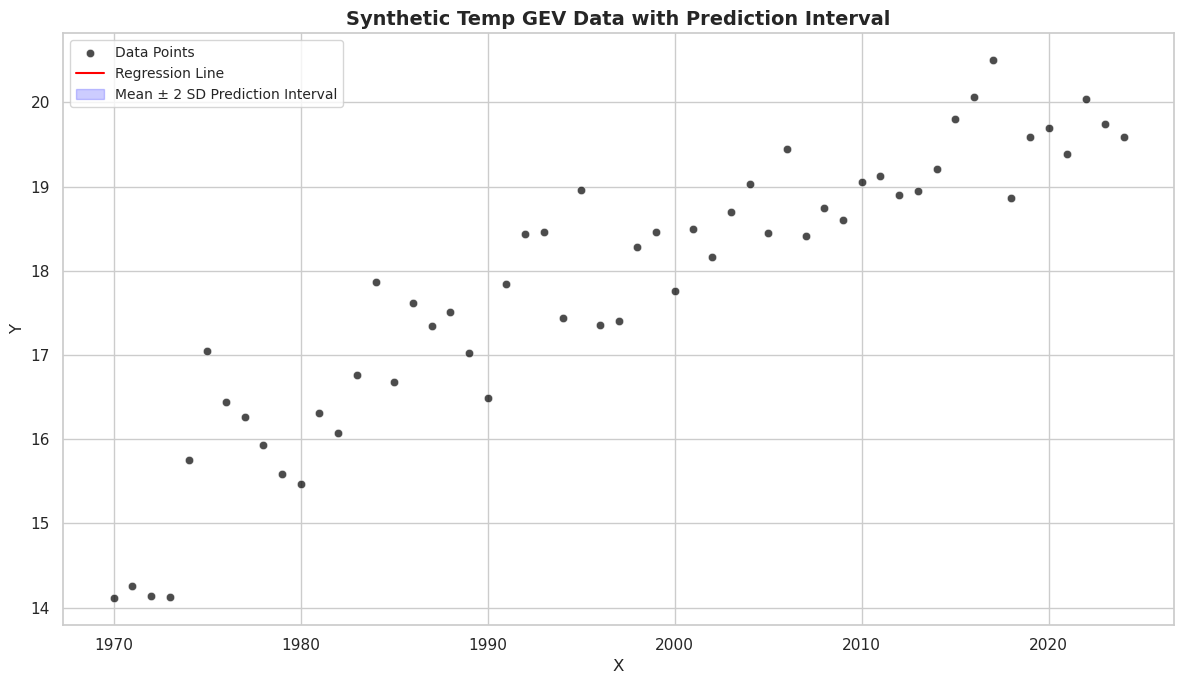

In [28]:
# Response is GPD GAMLSS Distributed Case
betas_loc = results_temp["transformed_loc_vi_parameters"]["betas_loc"]
betas_scale = results_temp["transformed_loc_vi_parameters"]["betas_scale"]
betas_shape = results_temp["transformed_loc_vi_parameters"]["betas_shape"]

X_min, X_max = X_temp.min(), X_temp.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "identity",
    intercept=True,
    standardize=True,
)()
linear_predictor_loc = X_line_design.matrix @ betas_loc
linear_predictor_scale = TransformationFunctions.softplus(
    X_line_design.matrix @ betas_scale
)
linear_predictor_shape = TransformationFunctions.tanh(X_line_design.matrix @ betas_shape)

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
GEV_mean = GEV.mean()
GEV_sd = GEV.stddev()

# GEV_mean = linear_predictor_loc + (
#     linear_predictor_scale / (1 - linear_predictor_shape)
# )
# GEV_variance = linear_predictor_scale**2 / (
#     (1 - linear_predictor_shape) ** 2 * (1 - 2 * linear_predictor_shape)
# )
# GEV_sd = jnp.sqrt(GEV_variance)

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

sns.scatterplot(
    x=np.array(X_temp), y=np.array(Y_temp), color="black", label="Data Points", alpha=0.7, ax=ax
)

# Plots the PSpline regression line
sns.lineplot(
    x=X_line, y=GEV_mean, color="red", label="Regression Line", ax=ax
)

# Calculate the standard deviation
Y_lower = GEV_mean - 2 * GEV_sd
Y_upper = GEV_mean + 2 * GEV_sd

# Add the two standard deviation interval
ax.fill_between(
    X_line,
    Y_lower,
    Y_upper,
    color="blue",
    alpha=0.2,
    label="Mean ± 2 SD Prediction Interval",
)

ax.legend(fontsize=10, loc="upper left")

ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic Temp GEV Data with Prediction Interval",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()

plt.show()

In [29]:
linear_predictor_shape

Array([9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
       9.99999997e-07, 9.99999997e-07, 9.99999997e-07, 9.99999997e-07,
      